# Perform a Text Classification on consumer complaint dataset
# (https://catalog.data.gov/dataset/consumer-complaint-database)

## Importing packages and loading data

In [1]:
# Import Packages

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
# Load data to the notebook using pandas
df = pd.read_csv('complaints.csv')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_21284\3868444108.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('complaints.csv')


###

## Explanatory Data Analysis and Feature Engineering

In [3]:
df.shape

(4101381, 18)

In [4]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-07-22,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"Nelnet, Inc.",IL,61103,NaN,NaN,Web,2023-08-23,Closed with explanation,Yes,NaN,7284490
1,2023-08-25,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",FL,33444,NaN,NaN,Web,2023-08-25,Closed with non-monetary relief,Yes,NaN,7588176
2,2023-08-24,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,Experian Information Solutions Inc.,NJ,07024,NaN,Other,Web,2023-08-24,In progress,Yes,NaN,7452639
3,2023-08-25,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"SANTANDER HOLDINGS USA, INC.",FL,33972,NaN,NaN,Web,2023-08-25,Closed with explanation,Yes,NaN,7512160
4,2023-08-23,"Credit reporting, credit repair services, or o...",Other personal consumer report,Incorrect information on your report,Information that should be on the report is mi...,NaN,NaN,LEXISNEXIS,FL,32258,NaN,Other,Web,2023-08-23,In progress,Yes,NaN,7442688


In [5]:
df.head(2).T

,0,1
Date received,2023-07-22,2023-08-25
Product,"Credit reporting, credit repair services, or o...",Credit reporting or other personal consumer re...
Sub-product,Credit reporting,Credit reporting
Issue,Incorrect information on your report,Incorrect information on your report
Sub-issue,Information belongs to someone else,Information belongs to someone else
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,"Nelnet, Inc.","EQUIFAX, INC."
State,IL,FL
ZIP code,61103,33444


###

### Features in the dataset that are not required to answer our multi-classification problem are present. We will create a new dataframe including the terms "Product" and "Consumer complaint narrative" (formerly known as "Consumer_complaint") for this text classification task.

In [6]:
# Creating a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

In [7]:
# Remove Null Values ie NaN
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])] 

In [8]:
# Rename the second column with similar shorter name
df1.columns = ['Product', 'Consumer_complaint']

In [9]:
df1.shape

(1485598, 2)

In [10]:
# Percentage of text complaints
total = df1['Consumer_complaint'].notnull().sum()
percentage = round((total/len(df)*100),1)
str(percentage)+' %'

'36.2 %'

### There are approximately 1485598 cases with text out of more than one million complaints, which is approximately 36% of the original dataset that is not null. There is still room for improvement with this number. Let's have a look at the several categories that will be used to categorise each complaint now.

###

In [11]:
pd.DataFrame(df.Product.unique()).values

array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Credit reporting or other personal consumer reports'],
       ['Student loan'],
       ['Checking or savings account'],
       ['Debt collection'],
       ['Mortgage'],
       ['Credit card or prepaid card'],
       ['Credit card'],
       ['Money transfer, virtual currency, or money service'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Vehicle loan or lease'],
       ['Prepaid card'],
       ['Debt or credit management'],
       ['Payday loan, title loan, or personal loan'],
       ['Bank account or service'],
       ['Consumer Loan'],
       ['Credit reporting'],
       ['Money transfers'],
       ['Payday loan'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

### There are 20 different groups or categories (target) to choose from. However, it has been noticed that certain classes can be found within other classes. For example, the category known as "Credit card or prepaid card" includes both the terms "Credit card" and "Prepaid card." Now, let's pretend there is a brand new issue about credit cards, and that we need to categorise it. This issue can be categorised as either a "Credit card" or a "Credit card or prepaid" complaint by the algorithm, and either choice would be appropriate. However, this would have an effect on the performance of the model. The names of a few of these categories were changed so that we could steer clear of this issue.

###

In [11]:
# The data was sampled because the computation requires a lot of CPU time.
df2 = df1.sample(10000, random_state=1).copy()

In [12]:
# Renaming categories
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
              'Credit card': 'Credit card or prepaid card',
              'Prepaid card': 'Credit card or prepaid card',
              'Payday loan': 'Payday loan, title loan, or personal loan',
              'Money transfer': 'Money transfer, virtual currency, or money service',
              'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [13]:
pd.DataFrame(df2.Product.unique())

,0
0,Mortgage
1,Debt collection
2,"Credit reporting, repair, or other"
3,Student loan
4,"Payday loan, title loan, or personal loan"
5,"Money transfer, virtual currency, or money ser..."
6,Checking or savings account
7,Credit card or prepaid card
8,Bank account or service
9,Vehicle loan or lease


###

### Now we have just 15 classes instead of 20.

### It is now necessary to assign a numerical value to each class so that our prediction model can more accurately comprehend the various categories.

In [14]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()

In [15]:
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [16]:
# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
1478466,Mortgage,LoanDepot has failed to deliver my escrow bala...,0
302862,Debt collection,Both the collections accounts on my report or ...,1
1165070,"Credit reporting, repair, or other",My name is XXXX XXXX this complaint is not mad...,2
2387392,Mortgage,XXXX/XXXX/2014Honorable XXXX XXXX : Hello. I w...,0
1014314,"Credit reporting, repair, or other",I discovered that some of the information on m...,2


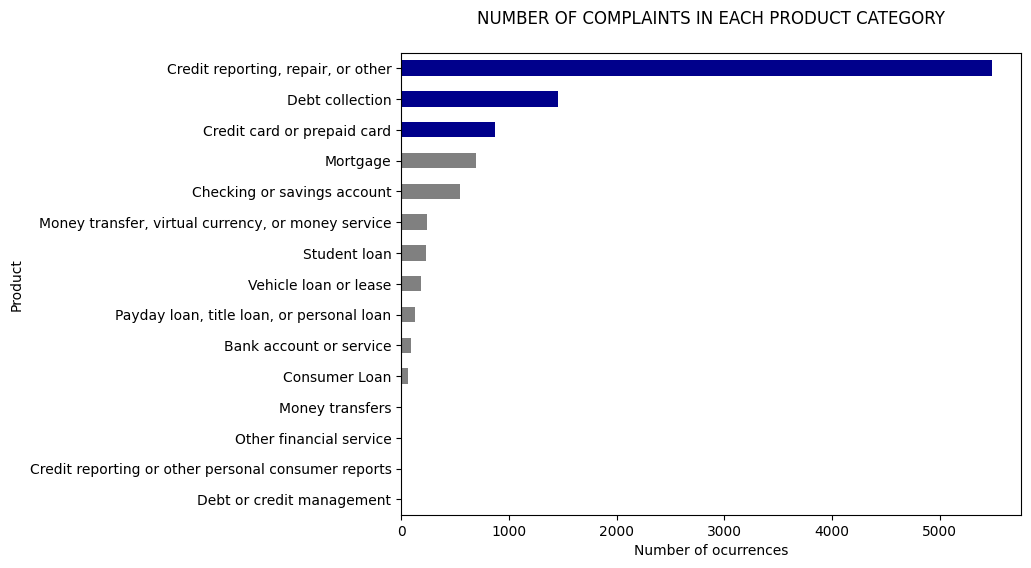

In [18]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey','grey',
          'grey','grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [19]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26010 features (TF-IDF score of unigrams and bigrams)


In [20]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Bank account or service:
  * Most Correlated Unigrams are: branch, 2016, overdraft
  * Most Correlated Bigrams are: xxxx 2016, deposited check, promotion code

==> Checking or savings account:
  * Most Correlated Unigrams are: overdraft, branch, checking
  * Most Correlated Bigrams are: overdraft fees, savings account, checking account

==> Consumer Loan:
  * Most Correlated Unigrams are: finance, car, avant
  * Most Correlated Bigrams are: separate accounts, calling times, toyota financial

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: citi, cards, card
  * Most Correlated Bigrams are: card company, american express, credit card

==> Credit reporting or other personal consumer reports:
  * Most Correlated Unigrams are: surrendered, wage, laugh
  * Most Correlated Bigrams are: collection charge, thank immediate, theft taken

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: report, section, reporting
  * Most Correlated Bigrams are: cre

###

## Spliting the data into train and test sets
### After separating the data into its features (X) and its target (y), it was subdivided further into test (75%) and train (25%) sets. Therefore, the algorithms would be trained on a single piece of data before being evaluated on an altogether new set of data (which the algorithm had never encountered before).

In [22]:
# Spliting Data into train and test dataset
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 15 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

###

## Selection and Building of Multi Classification Model

In [24]:
models = [
    DecisionTreeClassifier(max_depth=5, random_state=0),
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_split.

###

## Comparison of model performance

In [25]:
# Comparision of model
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
DecisionTreeClassifier,0.6730,0.004623
LinearSVC,0.8276,0.007553
LogisticRegression,0.8059,0.009229
MultinomialNB,0.6841,0.005650
RandomForestClassifier,0.5480,0.000000


###

### The best mean acuracy was obtained with LinearSVC for this dataset

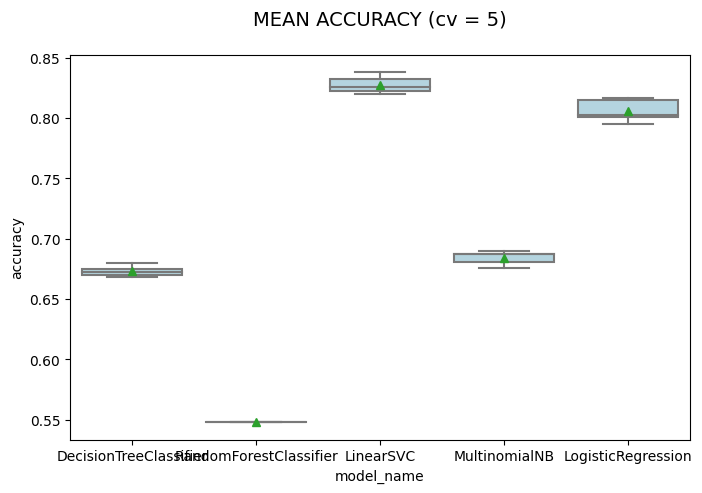

In [27]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', data=cv_df, color='lightblue', showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

###

## Model Evaluation

In [28]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

###

In [31]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS



ValueError: Number of classes, 13, does not match size of target_names, 15. Try specifying the labels parameter

## Confusion Matrix
### A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.

### If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).

### Overall, the confusion matrix exhibits favourable characteristics, with a distinct diagonal that accurately reflects the right classifications. However, there are instances in which the complaint was erroneously categorised into an incorrect class.

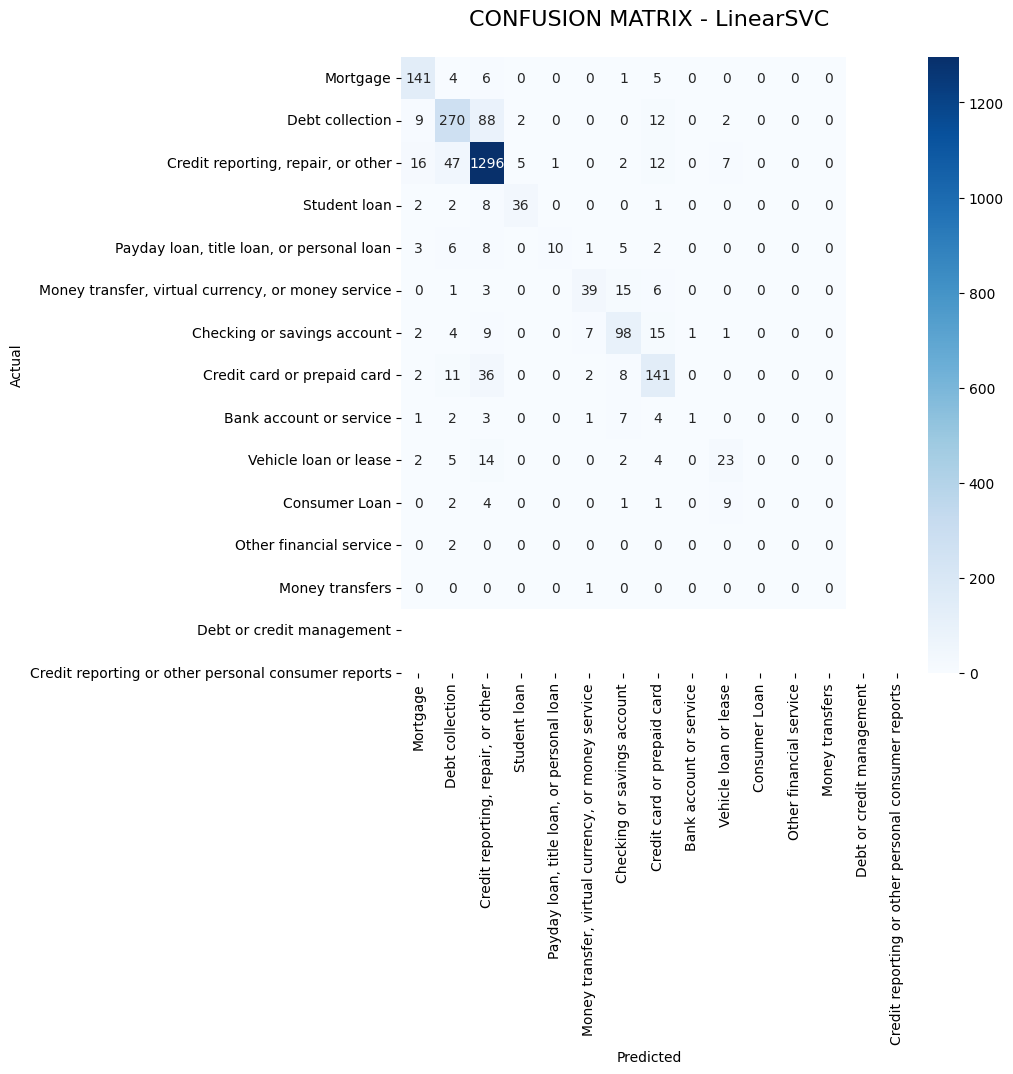

In [32]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

### 

### Most correlated terms with each category

In [35]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Bank account or service':
  * Top unigrams: 2016, bank, promotion, branch
  * Top bigrams: deposited check, xx 2016, letter send, xxxx 2016

==> 'Checking or savings account':
  * Top unigrams: bank, checking, account, chime
  * Top bigrams: checking account, response company, money account, access account

==> 'Consumer Loan':
  * Top unigrams: avant, finance, upload, thank
  * Top bigrams: paying monthly, supposed removed, history xxxx, calling times

==> 'Credit card or prepaid card':
  * Top unigrams: card, discover, capital, citi
  * Top bigrams: credit card, late fees, minimum payment, balance transfer

==> 'Credit reporting or other personal consumer reports':
  * Top unigrams: drive, wage, pandemic, protections
  * Top bigrams: theft taken, collection charge, wage garnishment, xxxx husband

==> 'Credit reporting, repair, or other':
  * Top unigrams: experian, equifax, transunion, report
  * Top bigrams: xxxx xxxx, xxxx reporting, late payments, account applied

==> 'Debt 

### 

## Prediction Model

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

###

## Predict Complains

In [37]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


In [41]:
new_complaint_2 = """After debt has already been paid, many consumers still receive calls from collectors. 
This proves frustrating to many as they are uninvolved with the situation and would like to remove themselves from the call list. 
Similarly, collectors are wasting their own time on the wrong individuals. 
Instead of focusing on important collection opportunities, they are contacting those who have already been dealt with. 
Technology can help ensure that collectors and debtors are on the same page at all times, not wasting either party’s time."""
print(model.predict(fitted_vectorizer.transform([new_complaint_3])))

['Credit reporting, repair, or other']
